In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from scipy.sparse import coo_matrix
%matplotlib inline

from lsq_code import remove_outlier, create_vandermonde, solve_linear_LS, solve_linear_LS_gd, mnist_pairwise_LS

# Other possibly useful functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

### Exercise 1

When $n=1$, we can fit a degree-$m$ polynomial by choosing $f_{j}(x)=x^{j-1}$ and $M=m+1$. 
In this case, it follows that $A_{i,j}=x_{i}^{j-1}$
and the matrix $A$ is called a Vandermonde matrix.
Write a function to create Vandermonde matrix **(5 pt)**

In [10]:
x = np.arange(1, 10)
create_vandermonde(x, 3)

array([[  1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.],
       [  1.,   3.,   9.,  27.],
       [  1.,   4.,  16.,  64.],
       [  1.,   5.,  25., 125.],
       [  1.,   6.,  36., 216.],
       [  1.,   7.,  49., 343.],
       [  1.,   8.,  64., 512.],
       [  1.,   9.,  81., 729.]])

### Exercise 2

Write a function to solve least-square problem via linear algebra **(5 pt)**

Implementation hint: check `numpy.linalg.lstsq`.

Using the setup in the previous example, try fitting the points $(1,2),(2,3),(3,5),(4,7),(5,11),(6,13)$
to a degree-2 polynomial.

Print the mean squared error. **(5 pt)**

Plot this polynomial (for $x\in[0,7]$) along with the data points to see the quality of fit. **(5 pt)**

normal equation polynomial fit is 0.2321 x^2 + 0.6893 x^1 + 0.9000
normal equation MSE is 0.1821


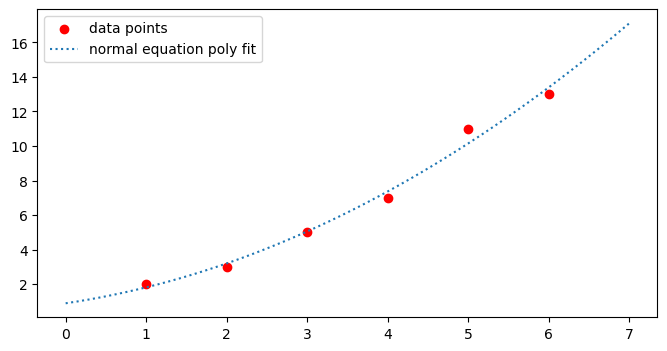

In [11]:
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([2, 3, 5, 7, 11, 13])
m = 2

# Create Vandermonde matrix A
A = create_vandermonde(x, m)

# Use linear algebra to solve least-squares problem and minimize || y - A z ||^2
z_hat = solve_linear_LS(A, y)

# Compute the mean squared error
mse = ((y - np.matmul(A,z_hat))**2).mean()

# Generate x/y plot points for the fitted polynomial
xx = np.linspace(0, 7)
yy = np.array([np.polyval(np.flip(z_hat),i) for i in xx])

plt.figure(figsize=(8, 4))
plt.scatter(x, y, color='red', label='data points')
plt.plot(xx, yy, linestyle='dotted',label='normal equation poly fit')
plt.legend()

poly1_expr = ' + '.join(['{0:.4f} x^{1}'.format(v, i) for i, v in enumerate(z_hat)][::-1])[:-4]
print('normal equation polynomial fit is {0}'.format(poly1_expr))
print('normal equation MSE is {0:.4f}'.format(mse))

### Exercise 3

Write a function to solve a least-squares problem via gradient descent. **(5 pt)**

Print the mean squared error. **(5 pt)**

Plot the resulting polynomial (for $x\in[0,7]$) along with previous polynomial and original data points to see the quality of fit. **(5 pt)**

gradient descent polynomial fit is 0.2038 x^2 + 0.8914 x^1 + 0.5995
gradient descent MSE is 0.1878
gradient descent MSE differece from LS: 3.0808%


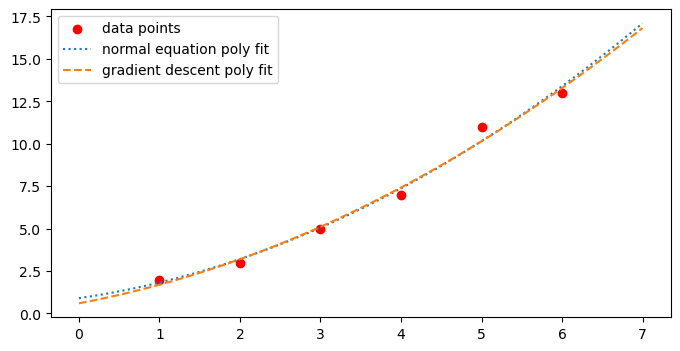

In [12]:
# Use gradient descent to solve least-squares problem and minimize || y - A z2 ||^2
z2_hat = solve_linear_LS_gd(A,y,0.0002,20000)

# Compute the mean squared error
mse2 = ((y - np.matmul(A,z2_hat))**2).mean()
difference = (mse2/mse) * 100.0

# Generate y plot points for the gd fitted polynomial
yy2 = np.array([np.polyval(np.flip(z2_hat),i) for i in xx])

plt.figure(figsize=(8, 4))
plt.scatter(x, y, color='red', label='data points')
plt.plot(xx, yy, linestyle='dotted',label='normal equation poly fit')
plt.plot(xx, yy2, linestyle='dashed', label='gradient descent poly fit')
plt.legend()

poly2_expr = ' + '.join(['{0:.4f} x^{1}'.format(v, i) for i, v in enumerate(z2_hat)][::-1])[:-4]
print('gradient descent polynomial fit is {0}'.format(poly2_expr))
print('gradient descent MSE is {0:.4f}'.format(mse2))
print('gradient descent MSE differece from LS: {0:.4f}%'.format(difference - 100))

#### MNIST

Read `mnist_train.csv`, create a dataframe with two columns, column `feature` contains all $x$ and column `label` contains all $y$.

Plot the first 30 images.

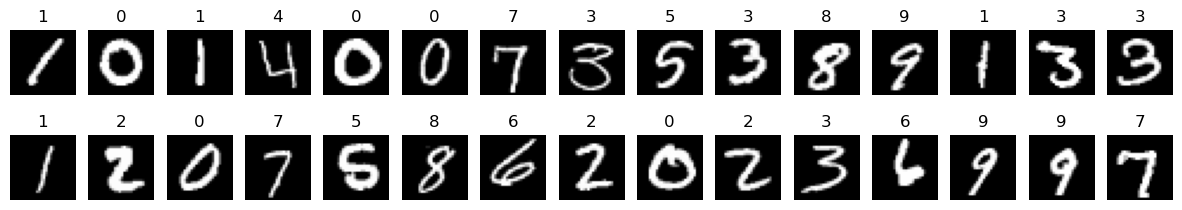

In [13]:
# read mnist csv file to a dataframe
df = pd.read_csv('mnist_train.csv')
# append feature column by merging all pixel columns
df['feature'] = df.apply(lambda row: row.values[1:], axis=1)
# only keep feature and label column
df = df[['feature', 'label']]
# display first 5 rows of the dataframe
df.head()

# Plot the first 30 images
plt.figure(figsize=(15, 2.5))
for i, row in df.iloc[:30].iterrows():
    x, y = row['feature'], row['label']
    plt.subplot(2, 15, i + 1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(y)

### Exercise 4

Write the function `extract_and_split` to extract the all samples labeled with digit $n$ and randomly separate fraction of samples into training and testing groups. **(10 pt)**

Implementation hint: check `sklearn.model_selection.train_test_split`.

Pairwise experiment for applying least-square to classify digit $a$ and digit $b$. 

Follow the given steps in the template and implement the `mnist_pairwise_LS` function for pairwise experiment **(15 pt)**

Possible implementation hint: check `sklearn.metrics.accuracy_score`, `sklearn.metrics.confusion_matrix`

Pairwise experiment, mapping 0 to -1, mapping 1 to 1
training error = 0.39%, testing error = 1.11%
Confusion matrix:
 [[2041   25]
 [  24 2318]]


array([0.00385662, 0.01111615])

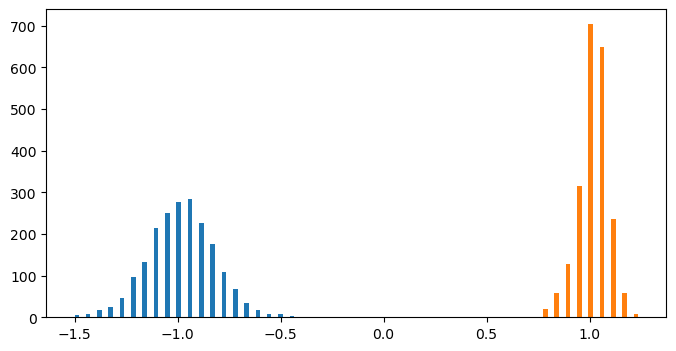

In [14]:
# Pairwise experiment for LSQ to classify between 0 and 1
mnist_pairwise_LS(df, 0, 1, verbose=True)

### Exercise 5

Repeat the above problem for all pairs of digits. For each pair of digits, report the classification error rates for the training and testing sets. The error rates can be formatted nicely into a triangular matrix.  Put testing error in the lower triangle and training error in the upper triangle.

The code is given here in order demonstrate tqdm.
Points awarded for reasonable values **(10 pt)**

In [15]:
from tqdm.notebook import tqdm
num_trial, err_matrix = 1, np.zeros((10, 10))
for a, b in tqdm(it.combinations(range(10), 2), total=45):
    err_tr, err_te = np.mean([mnist_pairwise_LS(df, a, b) for _ in range(num_trial)], axis=0)
    err_matrix[a, b], err_matrix[b, a] = err_tr, err_te

print(np.round(err_matrix*100, 2))

  0%|          | 0/45 [00:00<?, ?it/s]

[[0.   0.43 0.77 0.35 0.15 0.73 0.46 0.09 0.9  0.38]
 [0.95 0.   0.95 0.62 0.25 0.61 0.23 0.55 1.72 0.25]
 [2.26 2.62 0.   1.88 0.95 1.38 1.18 1.   1.7  0.96]
 [1.32 1.7  4.06 0.   0.19 2.8  0.26 0.78 2.52 1.26]
 [1.15 0.85 2.42 1.5  0.   0.69 0.37 0.73 0.49 2.25]
 [2.62 1.27 2.96 5.96 1.6  0.   1.69 0.15 2.44 1.  ]
 [1.86 1.16 2.28 1.25 1.07 4.01 0.   0.05 1.   0.17]
 [0.63 1.61 2.7  2.33 2.86 1.76 0.63 0.   0.64 2.82]
 [1.24 4.28 4.46 5.25 1.55 5.11 2.22 2.15 0.   1.41]
 [1.42 1.06 1.82 2.72 4.36 1.8  0.72 5.66 2.93 0.  ]]


### Exercise 6

But, what about a multi-class classifier for MNIST digits? 
For multi-class linear classification with d classes, one standard approach is to learn a linear mapping $f \colon \mathbb{R}^n \to \mathbb{R}^d $ where the “$y$”-value for the $i$-th class is chosen to be the standard basis vector $ \underline{e}_i \in \mathbb{R}^d $. 
This is sometimes called one-hot encoding. 
Using the same $A$ matrix as before and a matrix $Y$, defined by $Y_{i,j}$ if observation $i$ in class $j$ and $Y_{i,j} = 0$ otherwise, we can solve for the coefficient matrix $Z \in \mathbb{R}^d$ coefficients .
Then, the classifier maps a vector $\underline{x}$ to class $i$ if the $i$-th element of $Z^T \underline{x}$ is the largest element in the vector. 

Follow the steps in the template and implement the multi-class classification experiment **(20 pt)**

In [16]:
# Randomly split into training/testing set
test_size = 0.5
n, m = len(df), int(len(df) * test_size)
perm = np.random.permutation(n)
tr, te = df.iloc[perm[m:]], df.iloc[perm[:m]]

# Construct the training set
X_tr_data = np.stack(tr['feature'].to_numpy())
num_features = np.shape(X_tr_data)[1] + 1
num_samples_train = np.shape(X_tr_data)[0]
X_tr = np.zeros((num_samples_train,num_features))
X_tr[:,:-1] = X_tr_data
X_tr[:,num_features - 1] = -1
y_tr = np.stack(tr['label'].to_numpy())

# Construct the testing set
X_te_data = np.stack(te['feature'].to_numpy())
num_samples_test = np.shape(X_te_data)[0]
X_te = np.zeros((num_samples_test,num_features))
X_te[:,:-1] = X_te_data
X_te[:,num_features - 1] = -1
y_te = np.stack(te['label'].to_numpy())

# Apply one-hot encoding to training labels
max_y = np.max(df['label'].to_numpy())
min_y = np.min(df['label'].to_numpy())
num_labels = max_y - min_y + 1
Y = np.zeros((num_samples_train,num_labels))
for i in range(0,num_samples_train):
    Y[i,y_tr[i]] = 1

# Run least-square on training set
Z = np.linalg.lstsq(X_tr,Y,rcond=None)[0]

# Compute estimates and errors on training set
#Y_tr = np.matmul(X_tr,Z)
y_hat_tr = np.argmax(np.matmul(X_tr,Z),axis=1)
err_tr = 1 - accuracy_score(y_tr,y_hat_tr)

# Compute estimates and errors on training set
Y_te = np.matmul(X_te,Z)
y_hat_te = np.argmax(np.matmul(X_te,Z),axis = 1)
err_te = 1 - accuracy_score(y_te,y_hat_te)

print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
# Compute confusion matrix
cm = np.zeros((10, 10), dtype=np.int64)
for a in range(10):
    for b in range(10):
        cm[a, b] = ((y_te == a) & (y_hat_te == b)).sum()
print('Confusion matrix (test set):\n {0}'.format(cm))

cm = np.zeros((10, 10), dtype=np.int64)
for a in range(10):
    for b in range(10):
        cm[a, b] = ((y_tr == a) & (y_hat_tr == b)).sum()
print('Confusion matrix (training set):\n {0}'.format(cm))




training error = 13.29%, testing error = 15.77%
Confusion matrix (test set):
 [[1913    2    9    3    9   16   33    2   19    3]
 [   0 2300   13    9    4    9    6    5   24    3]
 [  42   97 1645   62   48    3   85   34   79   16]
 [  11   60   80 1761   11   44   16   38   51   37]
 [   4   32   21    3 1770   17   16    8   20  113]
 [  75   39   15  205   55 1344   65   21  122   43]
 [  51   26   20    0   31   35 1892    0   21    0]
 [  20   70    9   16   72    3    4 1860    8  119]
 [  22  161   24   82   45   72   22   10 1584   68]
 [  28   16    7   43  165    6    1  166   12 1619]]
Confusion matrix (training set):
 [[2054    2    3    8    9   12   17    0   17    1]
 [   1 2253    8    8    9    8    5    2   16    1]
 [  34   78 1681   56   39    2   76   31   63    6]
 [  12   54   52 1935   10   43   16   38   40   42]
 [   2   40   11    2 1857   23   17    3   12  101]
 [  44   34    9  161   36 1331   66   11   76   43]
 [  43   22   16    0   32   28 1914   